In [1]:
import os
import os.path as osp
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import pytorch3d as p3d

if sys.path[0] != "..":
    sys.path.insert(0, "..")

from ners import Ners, load_data_from_dir
from ners.pytorch3d import PerspectiveCameras, get_renderers
from ners.models import pretrain_template_uv, shape_model_to_mesh, TemplateUV

# Demo Notebook for NeRS

This notebook generates a NeRS model given images, masks, a cuboid initialization (user specified), and coarse poses (user specified).


Compute requirements: ~3-4 GPUs

Data requirements:
* Images: try to take 8-10 images, roughly in a turntable, under consistent illumination.
* Masks: you can use your favorite segmentation tool, such as [PointRend](https://github.com/facebookresearch/detectron2/tree/main/projects/PointRend) or [my interactive interface for GrabCut](https://github.com/jasonyzhang/interactive_grabcut).

File structure:
```
INPUT_DIR
|_ images
|___ image1.jpg
|___ ...
|_ masks
|___ image1.png  <- should have same filename as the images
|___ ...
```

Manual Input:
* Extents of the cuboid initialization
* Roughly binned camera poses (azimuth and elevation)

Lines that require manual input will have a `# TODO: Set this.`

Timings on 4x1080 TIs:
* Stage 1: 1.5 min
* Stage 2: 1.5 min
* Stage 3: 30 min
* Stage 4: 10 min
* Render a video: 4 min

In [2]:
device = torch.device("cuda:0")

INPUT_DIR = "../data/fruitlet"  # TODO: Set this.
OUTPUT_DIR = osp.join("../output", osp.basename(osp.normpath(INPUT_DIR)))

os.makedirs(OUTPUT_DIR, exist_ok=True)

renderer_textured, renderer_silhouette = get_renderers(device=device)

here


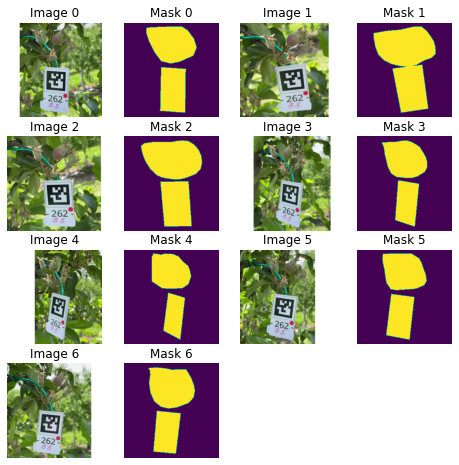

In [3]:
# Visualize the images and masks.

data = load_data_from_dir(INPUT_DIR)

n = len(data["images"])
num_rows = (n - 1) // 2 + 1
fig, axs = plt.subplots(num_rows, 4, figsize=(8, num_rows * 2))
axs = axs.flatten()
for i in range(n):
    image = data["images"][i]
    mask = data["masks"][i]
    axs[i * 2].imshow(image)
    axs[i * 2].set_title(f"Image {i}")
    axs[i * 2 + 1].imshow(mask)
    axs[i * 2 + 1].set_title(f"Mask {i}")
for ax in axs:
    ax.axis("off")

In [4]:
# TODO: Set this.
# Try to keep the largest dimension around 1.
template_extents = [0.7, 1, 1]  # [W, H, D].


# Pre-train the template shape.
f_template = pretrain_template_uv(
    template_uv=TemplateUV(),
    extents=template_extents,
    device=device,
)
template_mesh = shape_model_to_mesh(f_template)

# Save template shape.
template_path = osp.join(OUTPUT_DIR, "template.pth")
torch.save(f_template.state_dict(), template_path)

/home/frc-ag-3/.anaconda3/envs/ners/lib/python3.8/site-packages/pytorch3d/structures/meshes.py:1108: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  self._edges_packed = torch.stack([u // V, u % V], dim=1)


  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
# TODO: Set this.
azimuths = [0, 60, 270, 190, 210, 90, 270]  # In Degrees.
# TODO: Set this.
elevations = [30, 30, 0, 30, 30, 0, 90]  # In Degrees.

R, T = p3d.renderer.look_at_view_transform(
    dist=2,
    elev=elevations,
    azim=azimuths,
    device=device,
)
cameras = PerspectiveCameras(
    device=device,
    R=R,
    T=T,
    fov=60,
)

N = len(cameras)

rend = renderer_textured(template_mesh.extend(N), cameras=cameras)
fig, axs = plt.subplots(N, 2, figsize=(4, N * 2))
for i, (im, r) in enumerate(zip(data["images"], rend.detach().cpu()[..., :3])):
    axs[i, 0].imshow(im)
    axs[i, 0].set_title(f"Image {i}")
    axs[i, 1].imshow(r)
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
ners = Ners(
    images=data["images"],
    masks=data["masks"],
    masks_dt=data["masks_dt"],
    initial_poses=R.tolist(),
    image_center=data["image_centers"],
    crop_scale=data["crop_scales"],
    f_template=f_template,
    symmetrize=True,  # TODO: Set this to False for non-symmetric objects.
    num_layers_tex=12,
)

In [ ]:
ners.visualize_input_views(title="Initialization")

In [ ]:
ners.optimize_camera()
ners.visualize_input_views(title="Stage 1: Optimize Camera")

In [ ]:
ners.optimize_shape()
ners.visualize_input_views(title="Stage 2: Optimize $f_{shape}$")

In [ ]:
ners.optimize_texture(3000)
ners.visualize_input_views(title="Stage 3: Optimize $f_{tex}$")

In [ ]:
# Output 3D Mesh
mesh_path = osp.join(OUTPUT_DIR, "mesh.obj")
ners.save_obj(mesh_path)

In [ ]:
ners.optimize_radiance()
ners.visualize_input_views(title="Stage 4: Optimize $f_{env}$")

In [ ]:
# Output 360 degree video.
video_path = osp.join(OUTPUT_DIR, "video")
ners.make_video(video_path, image_size=512)

In [ ]:
from IPython.display import Video

Video(video_path + ".mp4", embed=True, width=600)

In [ ]:
torch.cuda.empty_cache()